# 目的

C100 (ノイズなしのクリーンな) に対して，各誤分類タイプ時の正解/不正解時の正解ラベルへの予測確率の違いを可視化する

python化したやつは `exp-fl-4-4.py` です

## import 部

In [54]:
from utils.vit_util import transforms_c100, get_batched_hs, get_batched_labels, ViTFromLastLayer, get_ori_model_predictions, identfy_tgt_misclf
from utils.constant import ViTExperiment
from utils.helper import get_device
from utils.de import set_new_weights
from transformers import ViTForImageClassification
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import os
from collections import defaultdict
import numpy as np
from datasets import load_from_disk
tgt_pos = ViTExperiment.CLS_IDX

## モデルのロード，隠れ状態キャッシュのロード，推論結果取得，データセットロード

In [55]:
pretrained_dir = ViTExperiment.c100.OUTPUT_DIR.format(k=0)
device = get_device()
# pretrained modelのロード
model = ViTForImageClassification.from_pretrained(pretrained_dir).to(device)
model.eval()
vit_from_last_layer = ViTFromLastLayer(model)
vit_from_last_layer.eval(); # セミコロンで出力を抑制

Device: cuda


In [56]:
cache_path = "/src/src/out_vit_c100_fold0/cache_hidden_states_before_layernorm_repair/hidden_states_before_layernorm_11.npy"
clean_hs = get_batched_hs(cache_path, batch_size=ViTExperiment.BATCH_SIZE)

In [57]:
all_logits = []
all_proba = []
all_pred_labels = []
for cached_state in tqdm(clean_hs, total=len(clean_hs)):
    # ここでViTFromLastLayerのforwardが実行される
    logits = vit_from_last_layer(hidden_states_before_layernorm=cached_state, tgt_pos=tgt_pos)
    proba = torch.nn.functional.softmax(logits, dim=-1)
    logits = logits.detach().cpu().numpy()
    proba = proba.detach().cpu().numpy()
    all_logits.append(logits)
    all_proba.append(proba)
all_logits = np.concatenate(all_logits, axis=0)
all_proba = np.concatenate(all_proba, axis=0)
all_pred_labels = all_logits.argmax(axis=-1)
print(f"all_logits.shape: {all_logits.shape}, all_proba.shape: {all_proba.shape}, all_pred_labels.shape: {all_pred_labels.shape}")

  0%|          | 0/313 [00:00<?, ?it/s]

all_logits.shape: (10000, 100), all_proba.shape: (10000, 100), all_pred_labels.shape: (10000,)


In [58]:
# datasetをロード (true_labelsが欲しいので)
ds_name, k = "c100", 0
ds_dirname = f"{ds_name}_fold{k}"
tgt_split = "repair"
ds = load_from_disk(os.path.join(ViTExperiment.DATASET_DIR, ds_dirname))
label_col = "fine_label"
# 正解ラベル
true_labels = np.array(ds[tgt_split][label_col])
# true_labelsとall_pred_labelsを比較して正解率を算出
is_correct = np.equal(true_labels, all_pred_labels)
is_correct = is_correct.astype(np.int32)
total_correct = np.sum(is_correct)
total = len(true_labels)
accuracy = total_correct / total
print(f"accuracy: {accuracy:.4f} ({total_correct}/{total})")

accuracy: 0.9074 (9074/10000)


## 正解ラベルに対する確率をプロット
正解時は高いが，不正解時は低いはず．

In [59]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Notebook向け
%matplotlib inline

def plot_hist(correct_confidences, incorrect_confidences):
    """
    正解時と不正解時の正解ラベルへの予測確率分布をプロットする
    """
    plt.figure(figsize=(8, 5))

    plt.hist(correct_confidences, bins=50, alpha=0.6, label='Correct', color='tab:blue', density=True)
    plt.hist(incorrect_confidences, bins=50, alpha=0.6, label='Incorrect', color='tab:red', density=True)

    plt.xlabel('Confidence for True Label', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.title('Confidence Distribution by Prediction Correctness', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

def plot_dot_violin(correct_confidences, incorrect_confidences, set_ylim=(0, 1), ylabel="Confidence for True Label", title="Confidence per Sample (Dot Plot)"):
    # データ整形（long formatに変換）
    data = np.concatenate([correct_confidences, incorrect_confidences])
    labels = (["Correct"] * len(correct_confidences)) + (["Incorrect"] * len(incorrect_confidences))
    
    plt.figure(figsize=(7, 5))
    sns.stripplot(x=labels, y=data, jitter=True, alpha=0.7, size=4, palette=["tab:blue", "tab:red"])
    # 参考でバイオリンも追加したい場合（コメントアウト可）
    # sns.violinplot(x=labels, y=data, inner=None, linewidth=1, palette=["tab:blue", "tab:red"], alpha=0.3)
    plt.xticks([0, 1], [
        f"Correct (n={len(correct_confidences)})",
        f"Incorrect (n={len(incorrect_confidences)})"
    ])
    
    # Y軸の制限（必要に応じて）
    if set_ylim is not None:
        plt.ylim(set_ylim)
    
    plt.ylabel(ylabel, fontsize=12)
    plt.title(title, fontsize=14)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()


misclf_type: all, tgt_rank: 1, fpfn: None
misclf_pair: None, tgt_label: None, len(tgt_mis_indices): 926
correct_confidences: (9074,), incorrect_confidences: (926,)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: Passing `palette` without assigning `hue` is deprecated.


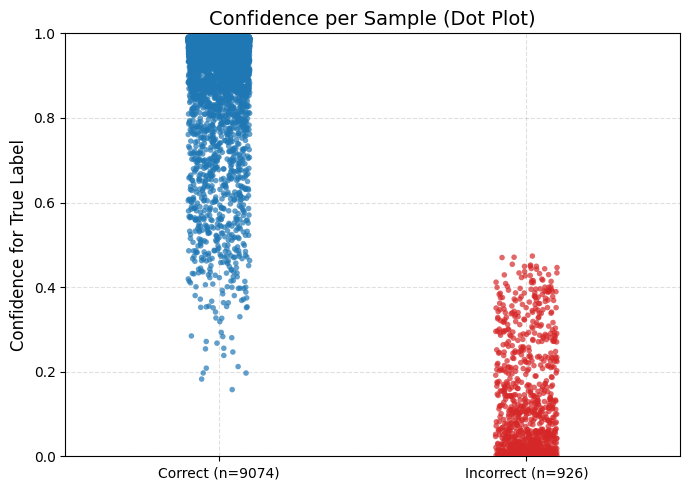


misclf_type: src_tgt, tgt_rank: 1, fpfn: None
misclf_pair: (52, 47), tgt_label: None, len(tgt_mis_indices): 19
correct_confidences: (9074,), incorrect_confidences: (19,)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: Passing `palette` without assigning `hue` is deprecated.


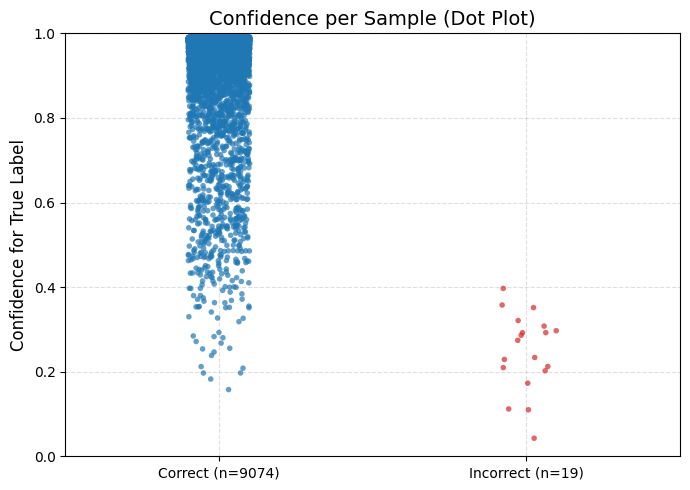


misclf_type: src_tgt, tgt_rank: 2, fpfn: None
misclf_pair: (61, 10), tgt_label: None, len(tgt_mis_indices): 16


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: Passing `palette` without assigning `hue` is deprecated.


correct_confidences: (9074,), incorrect_confidences: (16,)


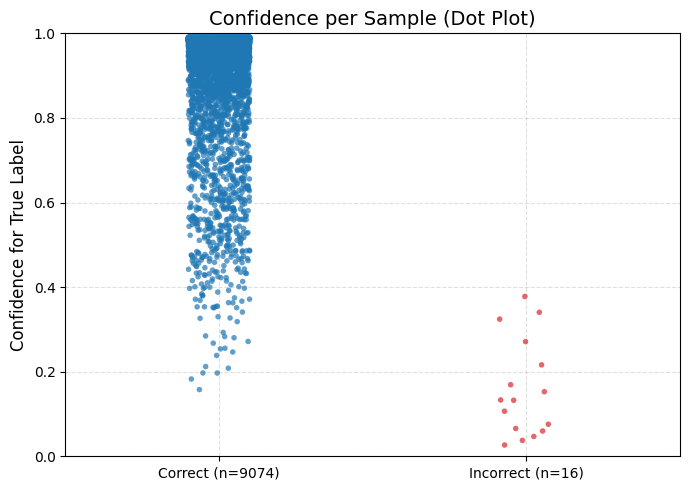


misclf_type: src_tgt, tgt_rank: 3, fpfn: None
misclf_pair: (11, 35), tgt_label: None, len(tgt_mis_indices): 14
correct_confidences: (9074,), incorrect_confidences: (14,)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: Passing `palette` without assigning `hue` is deprecated.


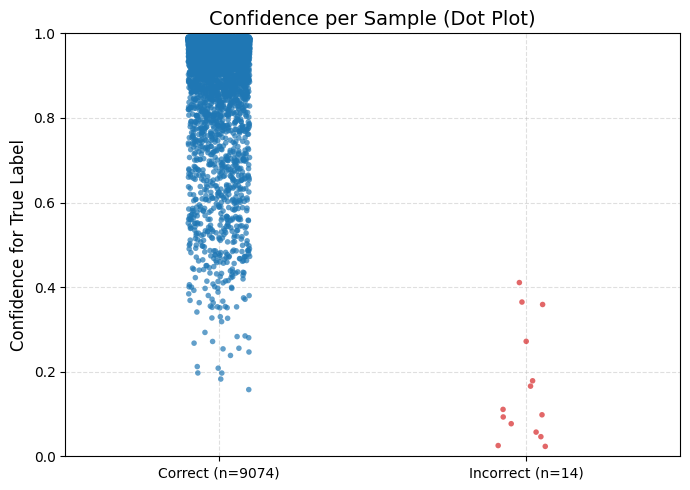


misclf_type: src_tgt, tgt_rank: 4, fpfn: None
misclf_pair: (2, 11), tgt_label: None, len(tgt_mis_indices): 13
correct_confidences: (9074,), incorrect_confidences: (13,)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: Passing `palette` without assigning `hue` is deprecated.


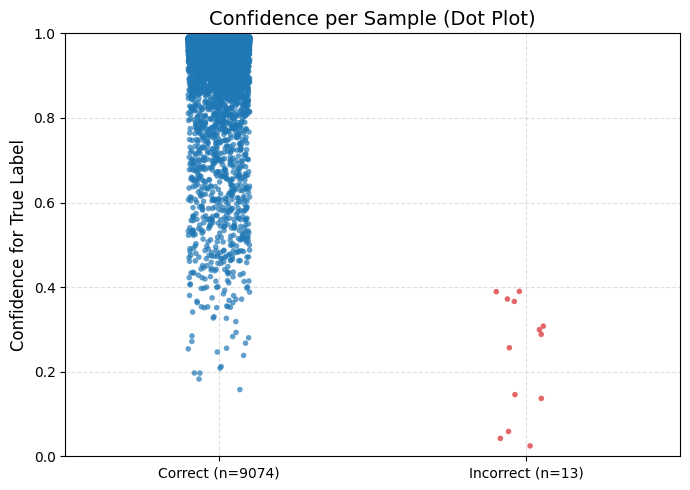


misclf_type: src_tgt, tgt_rank: 5, fpfn: None
misclf_pair: (11, 2), tgt_label: None, len(tgt_mis_indices): 13
correct_confidences: (9074,), incorrect_confidences: (13,)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: Passing `palette` without assigning `hue` is deprecated.


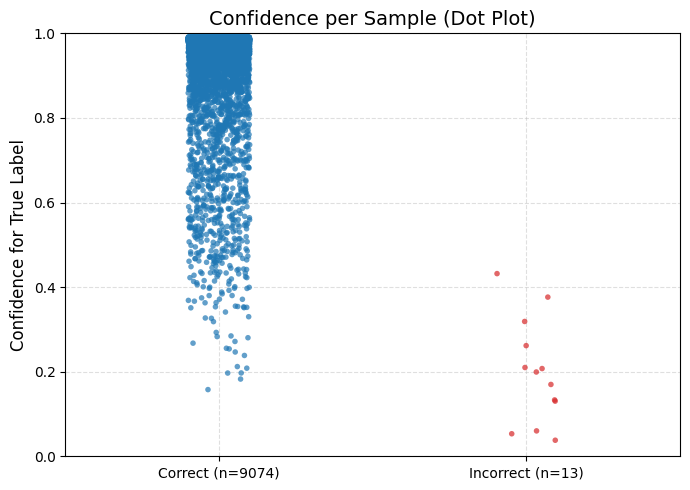


misclf_type: tgt, tgt_rank: 1, fpfn: None
misclf_pair: None, tgt_label: 47, len(tgt_mis_indices): 54
correct_confidences: (9074,), incorrect_confidences: (54,)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: Passing `palette` without assigning `hue` is deprecated.


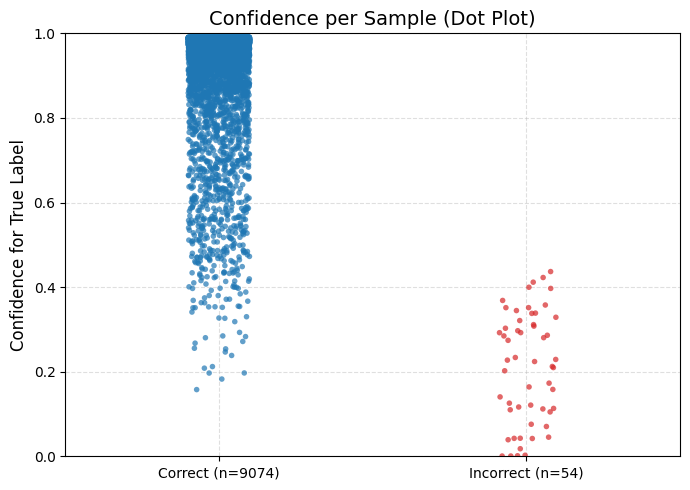


misclf_type: tgt, tgt_rank: 1, fpfn: fp
misclf_pair: None, tgt_label: 47, len(tgt_mis_indices): 27
correct_confidences: (9074,), incorrect_confidences: (27,)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: Passing `palette` without assigning `hue` is deprecated.


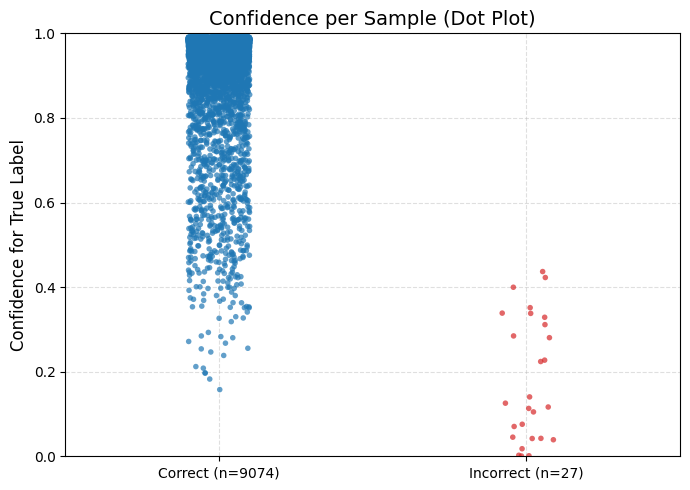


misclf_type: tgt, tgt_rank: 1, fpfn: fn
misclf_pair: None, tgt_label: 47, len(tgt_mis_indices): 27
correct_confidences: (9074,), incorrect_confidences: (27,)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: Passing `palette` without assigning `hue` is deprecated.


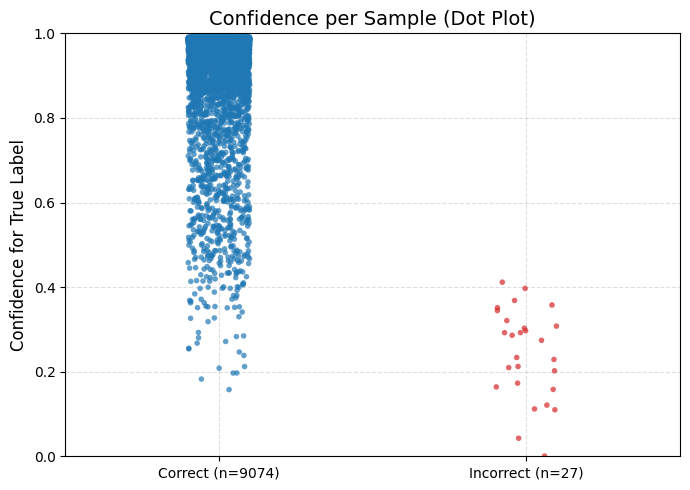


misclf_type: tgt, tgt_rank: 2, fpfn: None
misclf_pair: None, tgt_label: 11, len(tgt_mis_indices): 65
correct_confidences: (9074,), incorrect_confidences: (65,)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: Passing `palette` without assigning `hue` is deprecated.


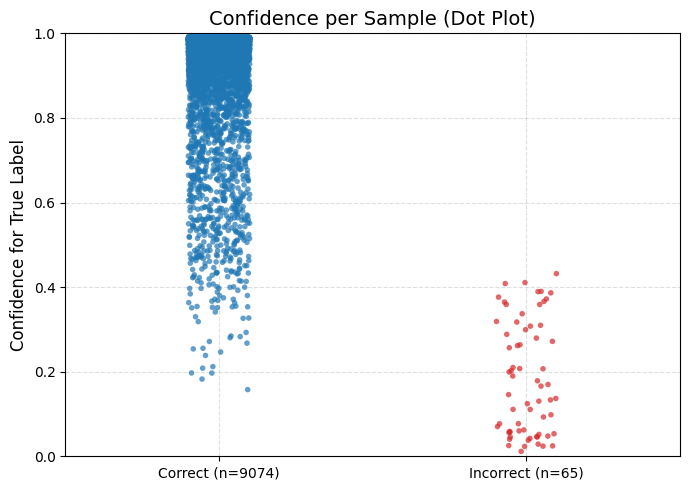


misclf_type: tgt, tgt_rank: 2, fpfn: fp
misclf_pair: None, tgt_label: 11, len(tgt_mis_indices): 32
correct_confidences: (9074,), incorrect_confidences: (32,)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: Passing `palette` without assigning `hue` is deprecated.


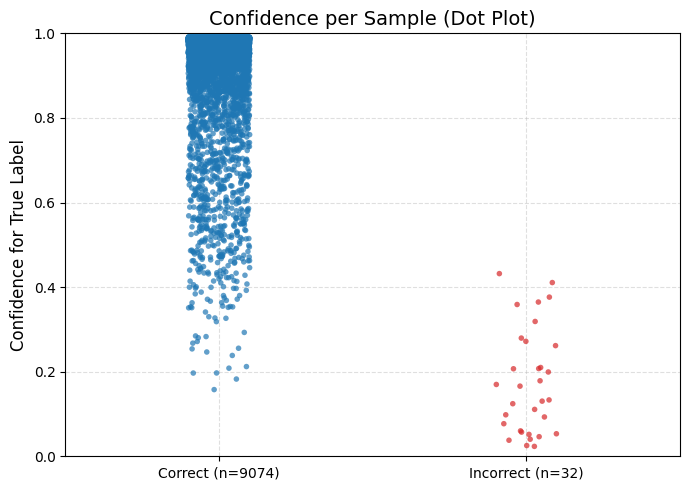


misclf_type: tgt, tgt_rank: 2, fpfn: fn


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: Passing `palette` without assigning `hue` is deprecated.


misclf_pair: None, tgt_label: 11, len(tgt_mis_indices): 33
correct_confidences: (9074,), incorrect_confidences: (33,)


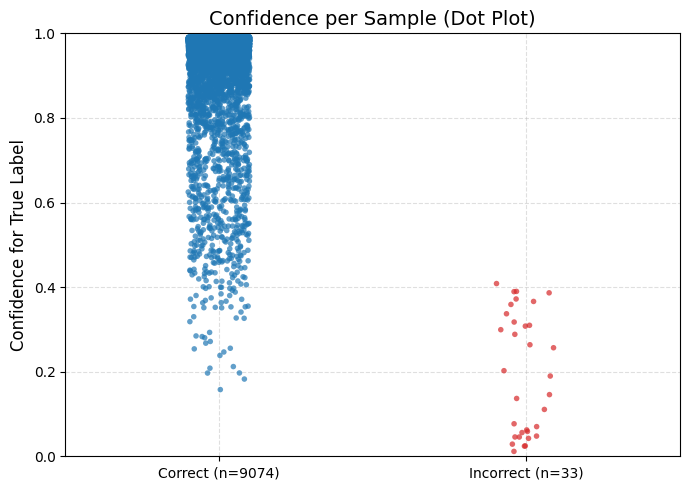


misclf_type: tgt, tgt_rank: 3, fpfn: None
misclf_pair: None, tgt_label: 35, len(tgt_mis_indices): 47
correct_confidences: (9074,), incorrect_confidences: (47,)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: Passing `palette` without assigning `hue` is deprecated.


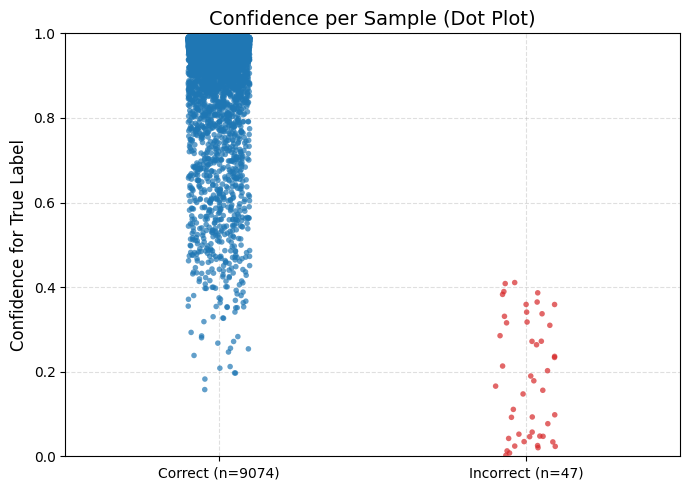


misclf_type: tgt, tgt_rank: 3, fpfn: fp
misclf_pair: None, tgt_label: 52, len(tgt_mis_indices): 31
correct_confidences: (9074,), incorrect_confidences: (31,)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: Passing `palette` without assigning `hue` is deprecated.


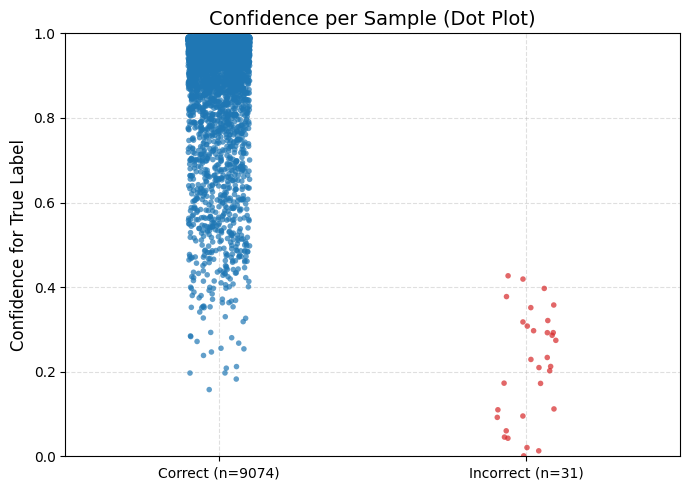


misclf_type: tgt, tgt_rank: 3, fpfn: fn


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: Passing `palette` without assigning `hue` is deprecated.


misclf_pair: None, tgt_label: 35, len(tgt_mis_indices): 27
correct_confidences: (9074,), incorrect_confidences: (27,)


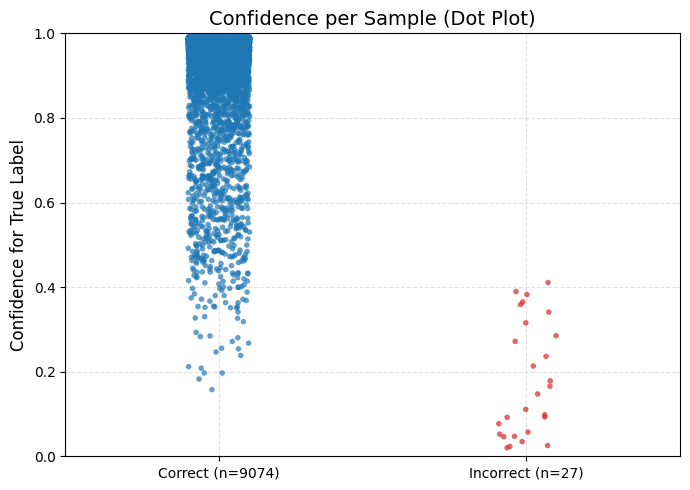


misclf_type: tgt, tgt_rank: 4, fpfn: None
misclf_pair: None, tgt_label: 10, len(tgt_mis_indices): 41
correct_confidences: (9074,), incorrect_confidences: (41,)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: Passing `palette` without assigning `hue` is deprecated.


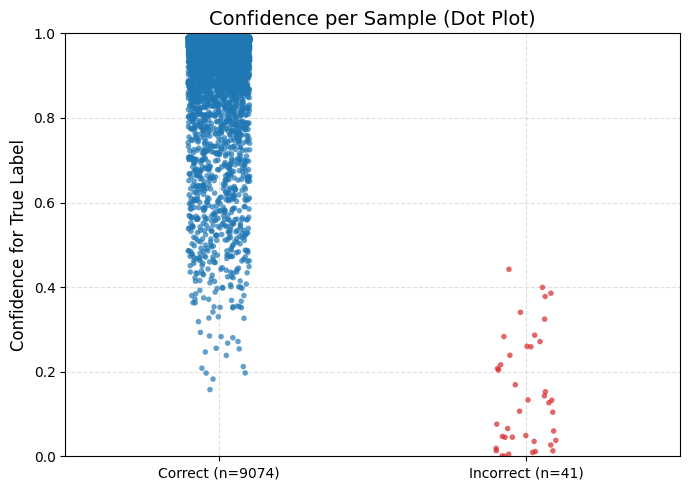


misclf_type: tgt, tgt_rank: 4, fpfn: fp
misclf_pair: None, tgt_label: 55, len(tgt_mis_indices): 26
correct_confidences: (9074,), incorrect_confidences: (26,)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: Passing `palette` without assigning `hue` is deprecated.


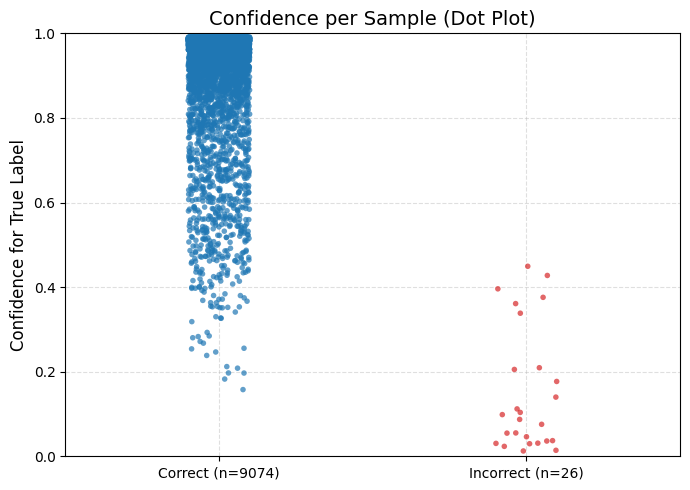


misclf_type: tgt, tgt_rank: 4, fpfn: fn
misclf_pair: None, tgt_label: 10, len(tgt_mis_indices): 26
correct_confidences: (9074,), incorrect_confidences: (26,)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: Passing `palette` without assigning `hue` is deprecated.


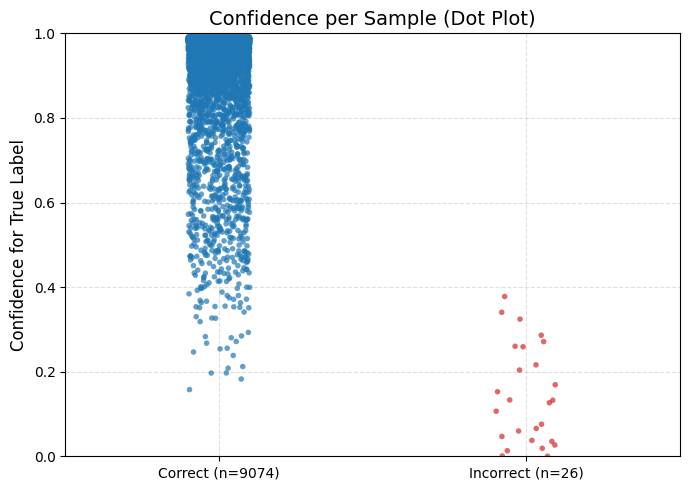


misclf_type: tgt, tgt_rank: 5, fpfn: None
misclf_pair: None, tgt_label: 55, len(tgt_mis_indices): 45
correct_confidences: (9074,), incorrect_confidences: (45,)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: Passing `palette` without assigning `hue` is deprecated.


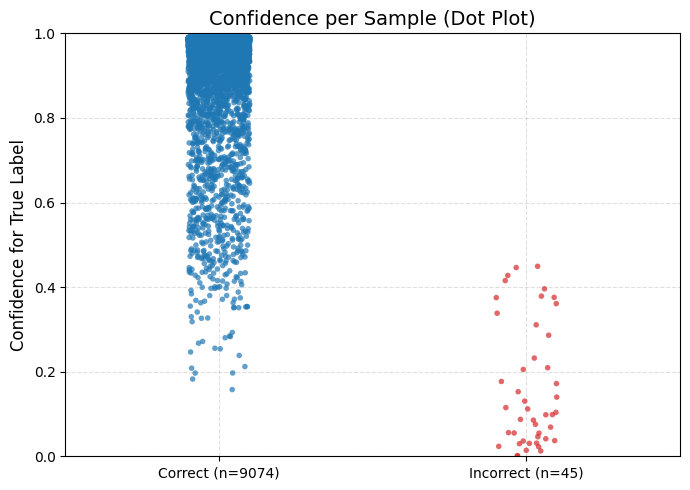


misclf_type: tgt, tgt_rank: 5, fpfn: fp
misclf_pair: None, tgt_label: 35, len(tgt_mis_indices): 20
correct_confidences: (9074,), incorrect_confidences: (20,)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: Passing `palette` without assigning `hue` is deprecated.


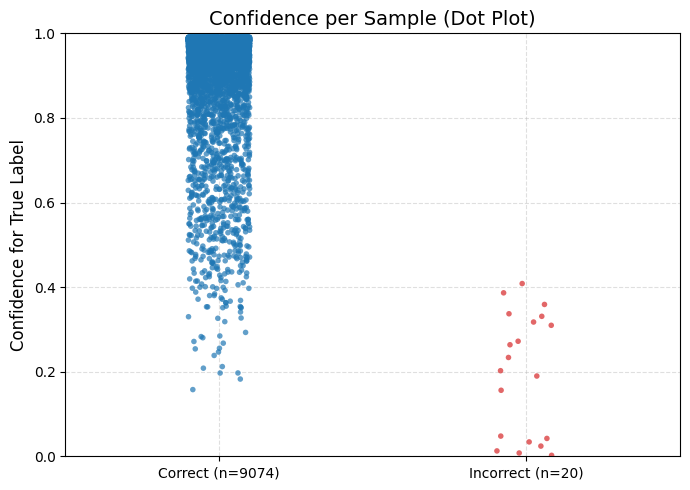

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: Passing `palette` without assigning `hue` is deprecated.



misclf_type: tgt, tgt_rank: 5, fpfn: fn
misclf_pair: None, tgt_label: 4, len(tgt_mis_indices): 20
correct_confidences: (9074,), incorrect_confidences: (20,)


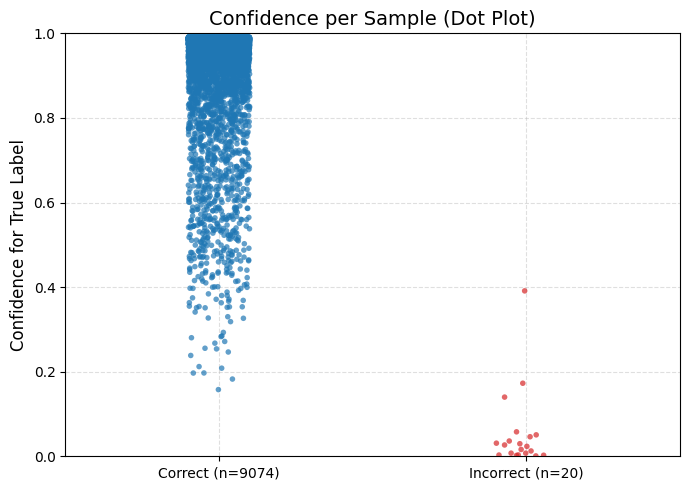

In [60]:
misclf_info_dir = "/src/src/out_vit_c100_fold0/misclf_info"
tgt_rank_list = range(1, 6)
misclf_type_list = ["all", "src_tgt", "tgt"]
fpfn_list = [None, "fp", "fn"]

for misclf_type in misclf_type_list:
    for tgt_rank in tgt_rank_list:
        for fpfn in fpfn_list:
            if misclf_type == "all":
                if tgt_rank >= 2 or fpfn is not None:
                    continue
            if misclf_type == "src_tgt" and fpfn is not None:
                    continue
            print(f"\nmisclf_type: {misclf_type}, tgt_rank: {tgt_rank}, fpfn: {fpfn}")
            misclf_pair, tgt_label, tgt_mis_indices = identfy_tgt_misclf(misclf_info_dir, tgt_split="repair", misclf_type=misclf_type, tgt_rank=tgt_rank, fpfn=fpfn)
            print(f"misclf_pair: {misclf_pair}, tgt_label: {tgt_label}, len(tgt_mis_indices): {len(tgt_mis_indices)}")
            
            # 正解時と不正解時の正解ラベルへの予測確率分布を出す
            correct_proba = all_proba[is_correct == 1]
            incorrect_proba = all_proba[tgt_mis_indices]
            labels_when_correct = true_labels[is_correct == 1]
            labels_when_incorrect = true_labels[tgt_mis_indices]
            correct_confidences = correct_proba[np.arange(len(correct_proba)), labels_when_correct]
            incorrect_confidences = incorrect_proba[np.arange(len(incorrect_proba)), labels_when_incorrect]
            print(f"correct_confidences: {correct_confidences.shape}, incorrect_confidences: {incorrect_confidences.shape}")

            plot_dot_violin(correct_confidences, incorrect_confidences)

## loss をプロット
all_probaとtrue_labelsからcelossを計算．

正解時は低いが，不正解時は高いはず．

In [61]:
# ロス計算のテスト
logits_tensor = torch.from_numpy(all_logits)
labels_tensor = torch.from_numpy(true_labels)
print(f"logits_tensor.shape: {logits_tensor.shape}, labels_tensor.shape: {labels_tensor.shape}")
criterion = nn.CrossEntropyLoss(reduction="none") # reduction="none"を指定すると、各サンプルのロスを個別に計算します
loss = criterion(logits_tensor, labels_tensor)
print(f"loss.shape: {loss.shape}")

logits_tensor.shape: torch.Size([10000, 100]), labels_tensor.shape: torch.Size([10000])
loss.shape: torch.Size([10000])



misclf_type: all, tgt_rank: 1, fpfn: None
misclf_pair: None, tgt_label: None, len(tgt_mis_indices): 926
correct_loss: torch.Size([9074]), incorrect_loss: torch.Size([926])


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: Passing `palette` without assigning `hue` is deprecated.


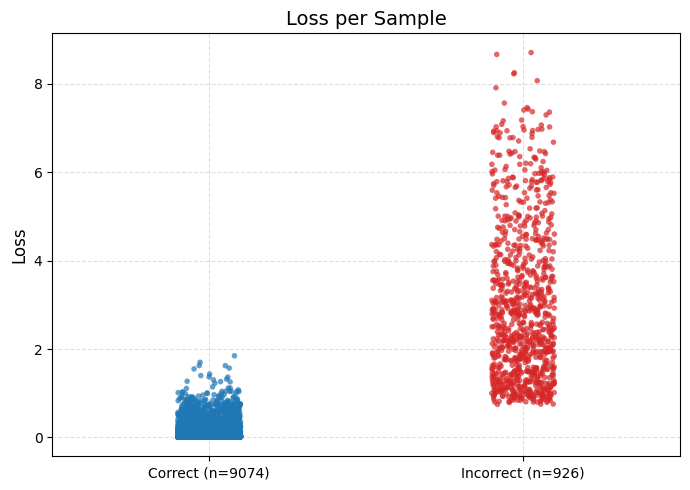


misclf_type: src_tgt, tgt_rank: 1, fpfn: None
misclf_pair: (52, 47), tgt_label: None, len(tgt_mis_indices): 19
correct_loss: torch.Size([9074]), incorrect_loss: torch.Size([19])


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: Passing `palette` without assigning `hue` is deprecated.


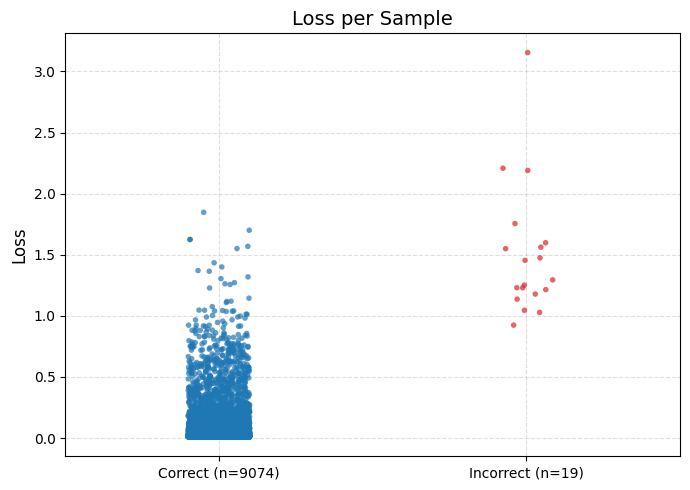


misclf_type: src_tgt, tgt_rank: 2, fpfn: None
misclf_pair: (61, 10), tgt_label: None, len(tgt_mis_indices): 16
correct_loss: torch.Size([9074]), incorrect_loss: torch.Size([16])


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: Passing `palette` without assigning `hue` is deprecated.


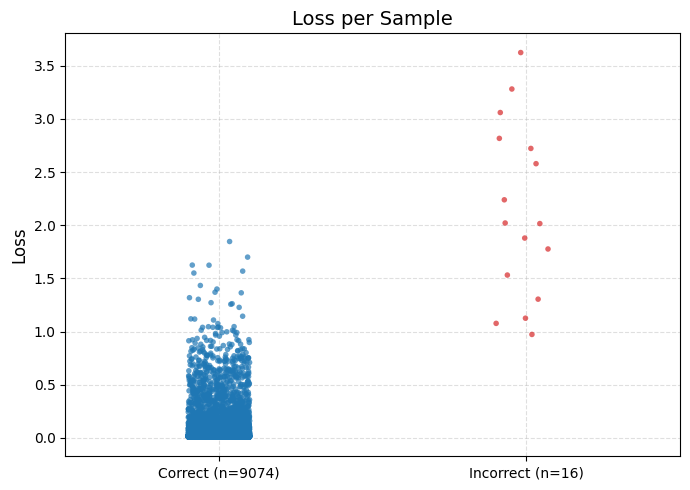


misclf_type: src_tgt, tgt_rank: 3, fpfn: None
misclf_pair: (11, 35), tgt_label: None, len(tgt_mis_indices): 14
correct_loss: torch.Size([9074]), incorrect_loss: torch.Size([14])


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: Passing `palette` without assigning `hue` is deprecated.


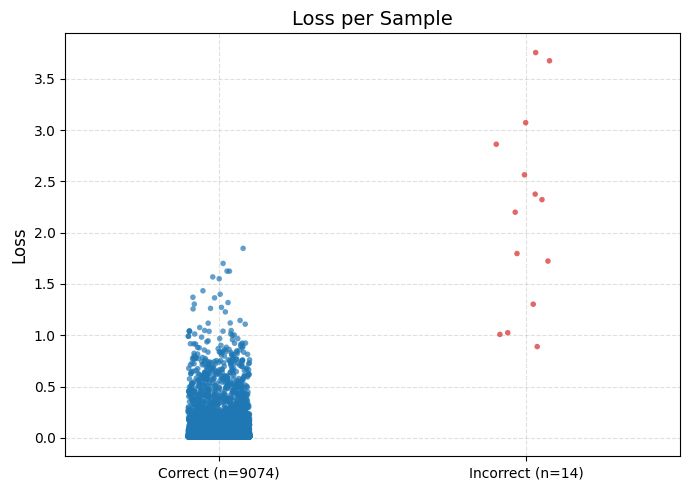


misclf_type: src_tgt, tgt_rank: 4, fpfn: None
misclf_pair: (2, 11), tgt_label: None, len(tgt_mis_indices): 13
correct_loss: torch.Size([9074]), incorrect_loss: torch.Size([13])


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: Passing `palette` without assigning `hue` is deprecated.


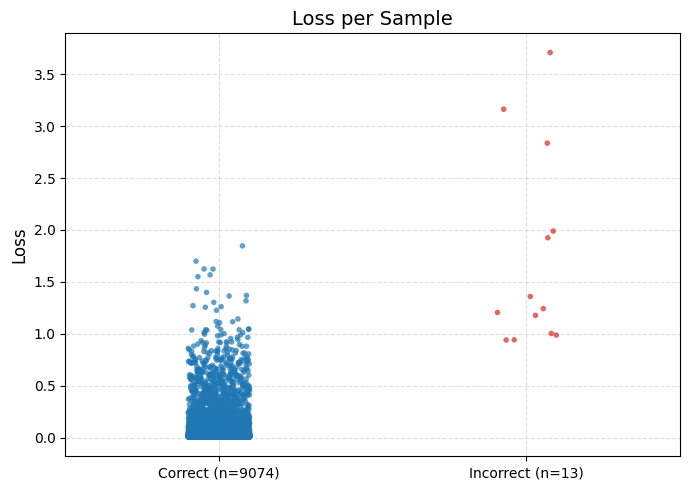


misclf_type: src_tgt, tgt_rank: 5, fpfn: None


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: Passing `palette` without assigning `hue` is deprecated.


misclf_pair: (11, 2), tgt_label: None, len(tgt_mis_indices): 13
correct_loss: torch.Size([9074]), incorrect_loss: torch.Size([13])


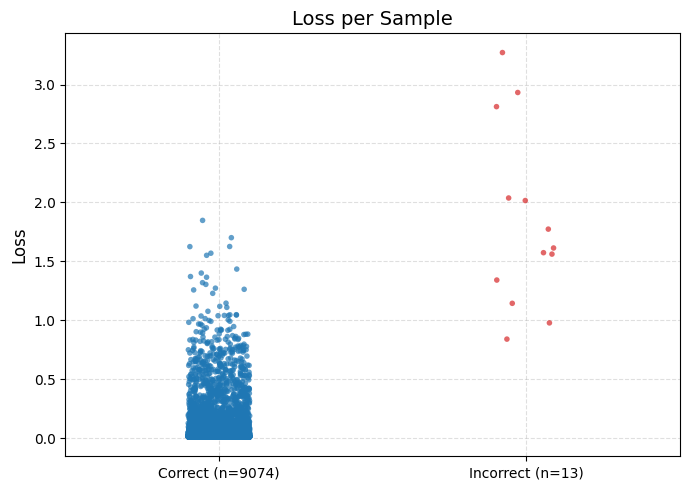


misclf_type: tgt, tgt_rank: 1, fpfn: None
misclf_pair: None, tgt_label: 47, len(tgt_mis_indices): 54
correct_loss: torch.Size([9074]), incorrect_loss: torch.Size([54])


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: Passing `palette` without assigning `hue` is deprecated.


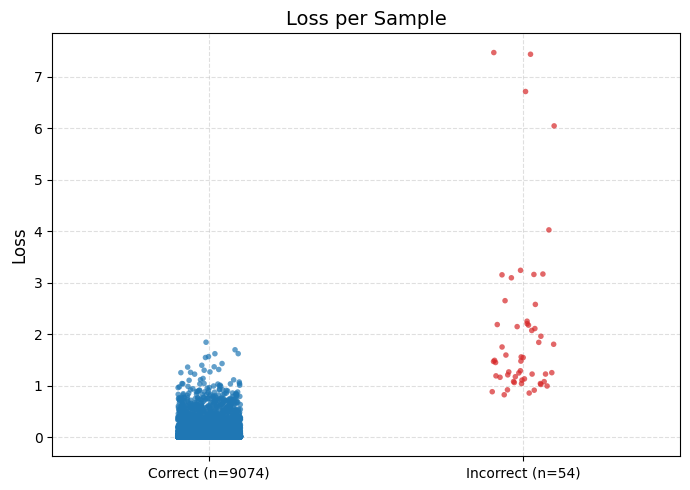


misclf_type: tgt, tgt_rank: 1, fpfn: fp
misclf_pair: None, tgt_label: 47, len(tgt_mis_indices): 27
correct_loss: torch.Size([9074]), incorrect_loss: torch.Size([27])


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: Passing `palette` without assigning `hue` is deprecated.


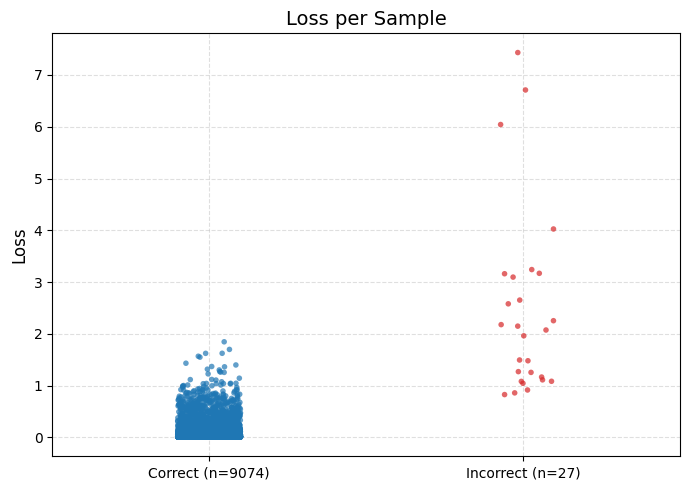


misclf_type: tgt, tgt_rank: 1, fpfn: fn
misclf_pair: None, tgt_label: 47, len(tgt_mis_indices): 27
correct_loss: torch.Size([9074]), incorrect_loss: torch.Size([27])


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: Passing `palette` without assigning `hue` is deprecated.


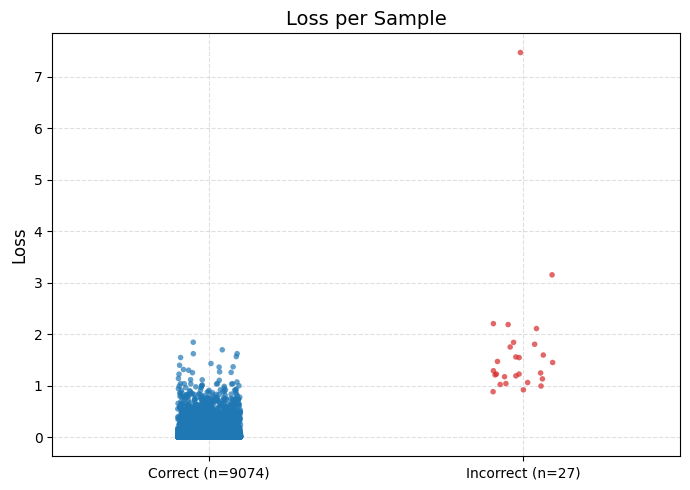


misclf_type: tgt, tgt_rank: 2, fpfn: None
misclf_pair: None, tgt_label: 11, len(tgt_mis_indices): 65
correct_loss: torch.Size([9074]), incorrect_loss: torch.Size([65])


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: Passing `palette` without assigning `hue` is deprecated.


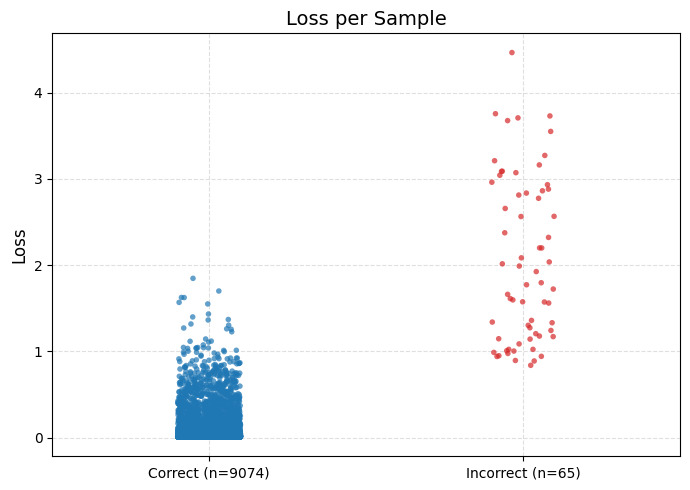


misclf_type: tgt, tgt_rank: 2, fpfn: fp
misclf_pair: None, tgt_label: 11, len(tgt_mis_indices): 32
correct_loss: torch.Size([9074]), incorrect_loss: torch.Size([32])


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: Passing `palette` without assigning `hue` is deprecated.


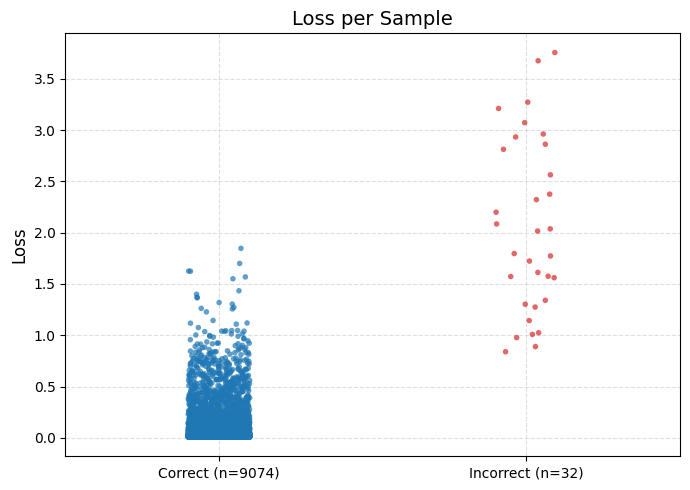


misclf_type: tgt, tgt_rank: 2, fpfn: fn
misclf_pair: None, tgt_label: 11, len(tgt_mis_indices): 33


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: Passing `palette` without assigning `hue` is deprecated.


correct_loss: torch.Size([9074]), incorrect_loss: torch.Size([33])


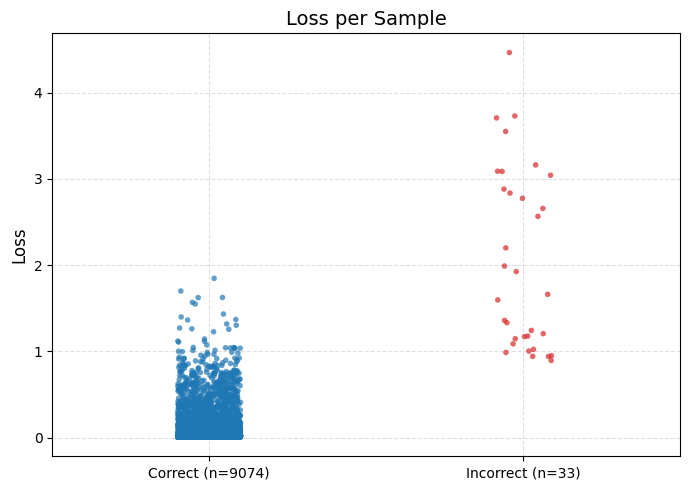


misclf_type: tgt, tgt_rank: 3, fpfn: None


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: Passing `palette` without assigning `hue` is deprecated.


misclf_pair: None, tgt_label: 35, len(tgt_mis_indices): 47
correct_loss: torch.Size([9074]), incorrect_loss: torch.Size([47])


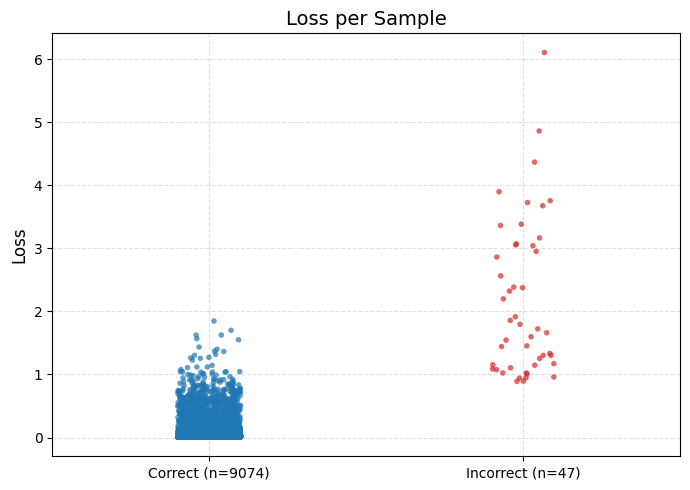


misclf_type: tgt, tgt_rank: 3, fpfn: fp
misclf_pair: None, tgt_label: 52, len(tgt_mis_indices): 31
correct_loss: torch.Size([9074]), incorrect_loss: torch.Size([31])


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: Passing `palette` without assigning `hue` is deprecated.


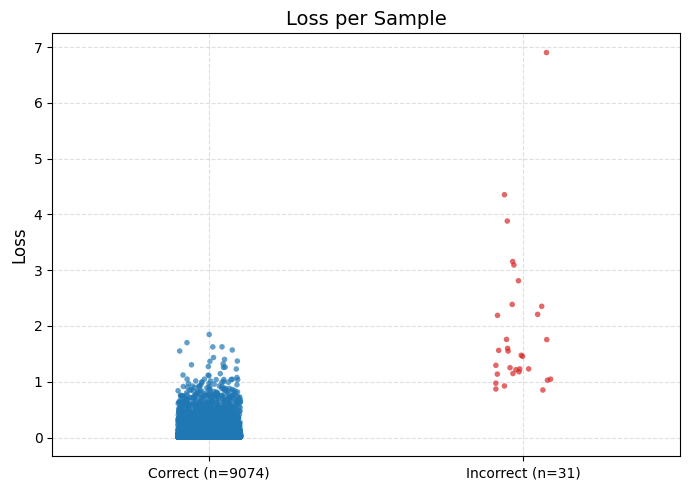


misclf_type: tgt, tgt_rank: 3, fpfn: fn
misclf_pair: None, tgt_label: 35, len(tgt_mis_indices): 27
correct_loss: torch.Size([9074]), incorrect_loss: torch.Size([27])


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: Passing `palette` without assigning `hue` is deprecated.


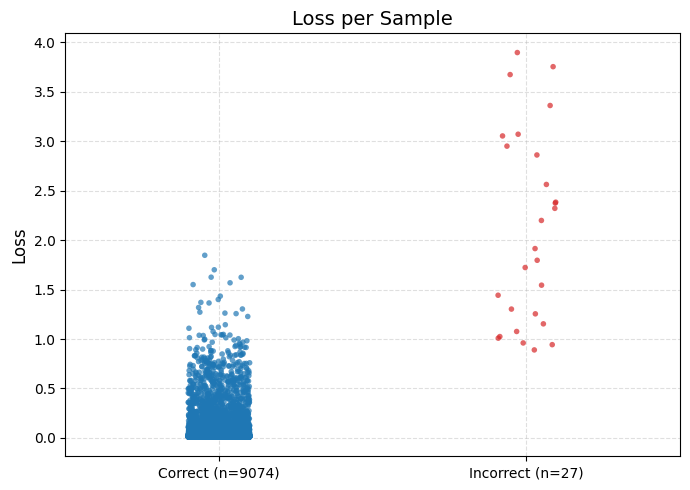


misclf_type: tgt, tgt_rank: 4, fpfn: None
misclf_pair: None, tgt_label: 10, len(tgt_mis_indices): 41
correct_loss: torch.Size([9074]), incorrect_loss: torch.Size([41])


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: Passing `palette` without assigning `hue` is deprecated.


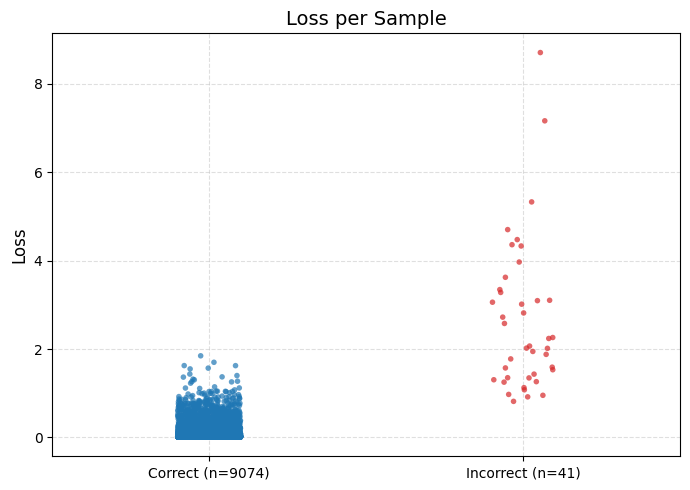


misclf_type: tgt, tgt_rank: 4, fpfn: fp
misclf_pair: None, tgt_label: 55, len(tgt_mis_indices): 26
correct_loss: torch.Size([9074]), incorrect_loss: torch.Size([26])


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: Passing `palette` without assigning `hue` is deprecated.


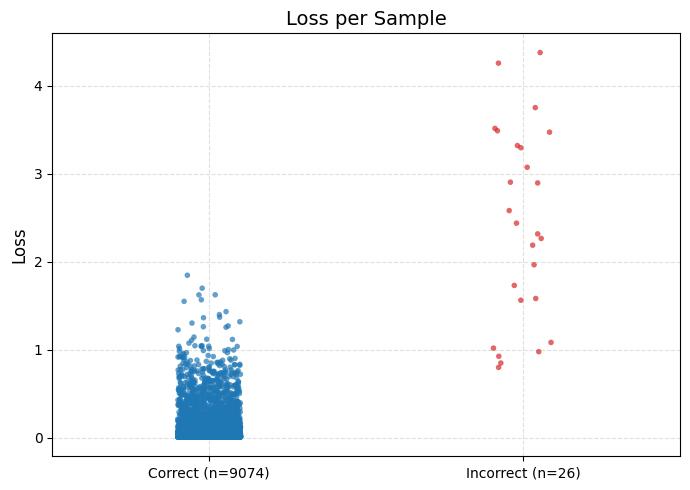


misclf_type: tgt, tgt_rank: 4, fpfn: fn
misclf_pair: None, tgt_label: 10, len(tgt_mis_indices): 26
correct_loss: torch.Size([9074]), incorrect_loss: torch.Size([26])


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: Passing `palette` without assigning `hue` is deprecated.


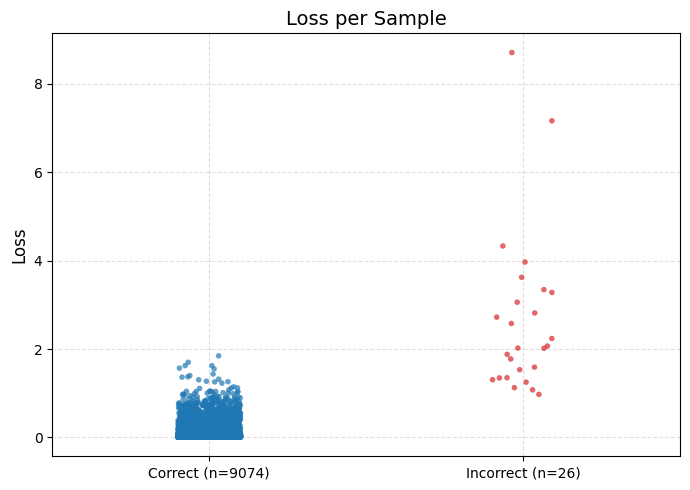


misclf_type: tgt, tgt_rank: 5, fpfn: None
misclf_pair: None, tgt_label: 55, len(tgt_mis_indices): 45
correct_loss: torch.Size([9074]), incorrect_loss: torch.Size([45])


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: Passing `palette` without assigning `hue` is deprecated.


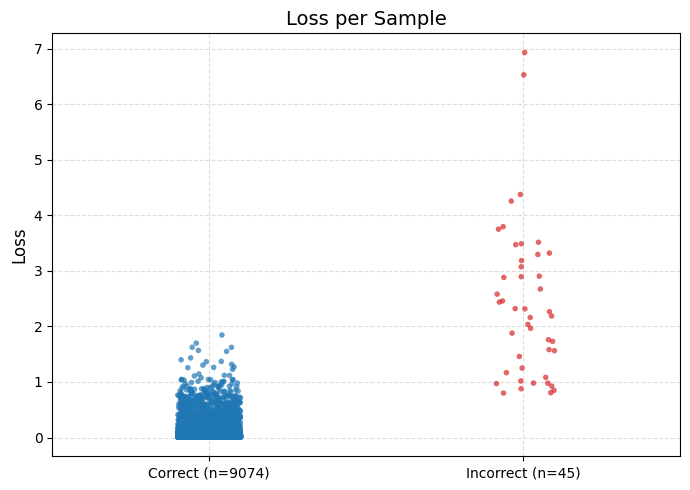

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: Passing `palette` without assigning `hue` is deprecated.



misclf_type: tgt, tgt_rank: 5, fpfn: fp
misclf_pair: None, tgt_label: 35, len(tgt_mis_indices): 20
correct_loss: torch.Size([9074]), incorrect_loss: torch.Size([20])


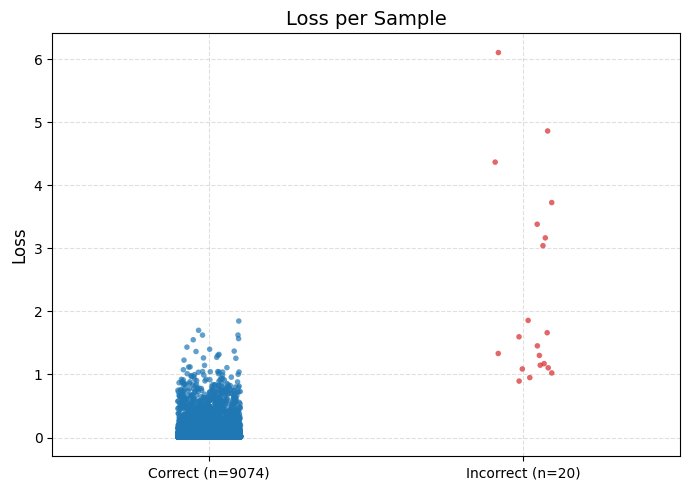


misclf_type: tgt, tgt_rank: 5, fpfn: fn
misclf_pair: None, tgt_label: 4, len(tgt_mis_indices): 20
correct_loss: torch.Size([9074]), incorrect_loss: torch.Size([20])


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: Passing `palette` without assigning `hue` is deprecated.


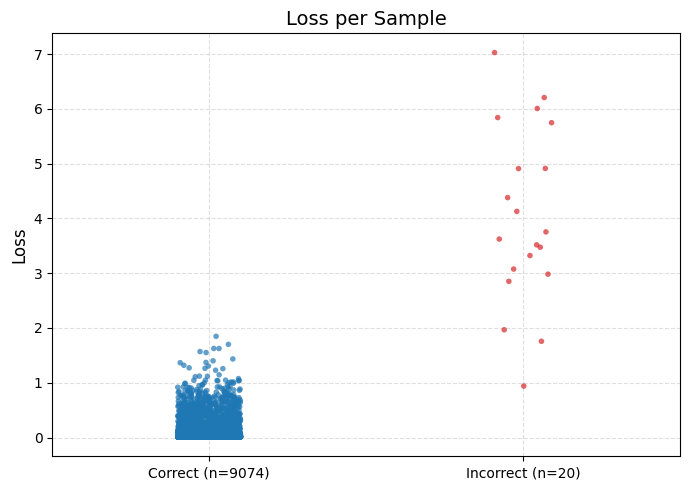

In [62]:
misclf_info_dir = "/src/src/out_vit_c100_fold0/misclf_info"
tgt_rank_list = range(1, 6)
misclf_type_list = ["all", "src_tgt", "tgt"]
fpfn_list = [None, "fp", "fn"]

criterion = nn.CrossEntropyLoss(reduction="none") # reduction="none"を指定すると、各サンプルのロスを個別に計算します

# NumPy → Tensor に変換
logits_tensor = torch.from_numpy(all_logits)
labels_tensor = torch.from_numpy(true_labels)

for misclf_type in misclf_type_list:
    for tgt_rank in tgt_rank_list:
        for fpfn in fpfn_list:
            if misclf_type == "all":
                if tgt_rank >= 2 or fpfn is not None:
                    continue
            if misclf_type == "src_tgt" and fpfn is not None:
                    continue
            print(f"\nmisclf_type: {misclf_type}, tgt_rank: {tgt_rank}, fpfn: {fpfn}")
            misclf_pair, tgt_label, tgt_mis_indices = identfy_tgt_misclf(misclf_info_dir, tgt_split="repair", misclf_type=misclf_type, tgt_rank=tgt_rank, fpfn=fpfn)
            print(f"misclf_pair: {misclf_pair}, tgt_label: {tgt_label}, len(tgt_mis_indices): {len(tgt_mis_indices)}")
            # 正解時と不正解時のロスをプロット
            labels_when_correct = labels_tensor[is_correct == 1]
            labels_when_incorrect = labels_tensor[tgt_mis_indices]
            correct_loss = criterion(logits_tensor[is_correct == 1], labels_when_correct)
            incorrect_loss = criterion(logits_tensor[tgt_mis_indices], labels_when_incorrect)
            print(f"correct_loss: {correct_loss.shape}, incorrect_loss: {incorrect_loss.shape}")

            plot_dot_violin(correct_loss, incorrect_loss, set_ylim=None, ylabel="Loss", title="Loss per Sample")

## tgt_rank = 1 に限って，true label marginをプロット．

true label margin = 予測ラベルへの確率 - 正解ラベルへの確率．
正解時は0で，不正解時は正の値．

あとでdiffを比較するので辞書にmarginやlossを入れとく．

In [63]:
misclf_info_dir = "/src/src/out_vit_c100_fold0/misclf_info"
# tgt_rank_list = range(1, 6)
tgt_rank_list = [1]
misclf_type_list = ["all", "src_tgt", "tgt"]
fpfn_list = [None, "fp", "fn"]

# ここで結果を格納する辞書を定義する
# キー: (misclf_type, tgt_rank, fpfn)
# 値: {"correct": correct_indices, "incorrect": incorrect_indices}
results_dict = {}

# NumPy → Tensor に変換
logits_tensor = torch.from_numpy(all_logits)
labels_tensor = torch.from_numpy(true_labels)

for misclf_type in misclf_type_list:
    for tgt_rank in tgt_rank_list:
        for fpfn in fpfn_list:
            if misclf_type == "all":
                if tgt_rank >= 2 or fpfn is not None:
                    continue
            if misclf_type == "src_tgt" and fpfn is not None:
                    continue
            print(f"\nmisclf_type: {misclf_type}, tgt_rank: {tgt_rank}, fpfn: {fpfn}")
            misclf_pair, tgt_label, tgt_mis_indices = identfy_tgt_misclf(misclf_info_dir, tgt_split="repair", misclf_type=misclf_type, tgt_rank=tgt_rank, fpfn=fpfn)
            print(f"misclf_pair: {misclf_pair}, tgt_label: {tgt_label}, len(tgt_mis_indices): {len(tgt_mis_indices)}")
            
            # ここで「オリジナルのモデルが正解したサンプル全体のインデックス」を取得
            # is_correct は 0/1 (または bool) で形状 (N,) を想定
            correct_indices = np.where(is_correct == 1)[0]

            # tgt_mis_indices がこの誤分類条件に当てはまるサンプルのインデックス
            incorrect_indices = tgt_mis_indices
            
            # 正解時と不正解時の正解ラベルへの予測確率分布を出す
            correct_proba = all_proba[is_correct == 1]
            incorrect_proba = all_proba[tgt_mis_indices]
            # 予測値最大のラベルのリスト
            top_indices_correct = correct_proba.argmax(axis=1)  # shape: (num_correct,)
            top_indices_incorrect = incorrect_proba.argmax(axis=1)  # shape: (num_incorrect,)
            # 予測値最大の確率値(予測値)のリスト
            top_confidences_correct = correct_proba[
                np.arange(len(correct_proba)), 
                top_indices_correct
            ]
            top_confidences_incorrect = incorrect_proba[
                np.arange(len(incorrect_proba)), 
                top_indices_incorrect
            ]
            # 正解時/不正解時それぞれの正解ラベルのリスト
            labels_when_correct = labels_tensor[is_correct == 1]
            labels_when_incorrect = labels_tensor[tgt_mis_indices]
            # 正解時/不正解時それぞれの正解ラベルへの予測確率値のリスト
            correct_confidences = correct_proba[np.arange(len(correct_proba)), labels_when_correct]
            incorrect_confidences = incorrect_proba[np.arange(len(incorrect_proba)), labels_when_incorrect]
            diff_correct = top_confidences_correct - correct_confidences
            diff_incorrect = top_confidences_incorrect - incorrect_confidences
            print(f"diff_correct: {diff_correct.shape}, diff_incorrect: {diff_incorrect.shape}")
            # plot_dot_violin(diff_correct, diff_incorrect)
            
            # ロス
            correct_loss = criterion(logits_tensor[is_correct == 1], labels_when_correct)
            incorrect_loss = criterion(logits_tensor[tgt_mis_indices], labels_when_incorrect)
            print(f"correct_loss: {correct_loss.shape}, incorrect_loss: {incorrect_loss.shape}")
            
            # 結果を辞書に保存する (キー: (misclf_type, tgt_rank, fpfn))
            key = (misclf_type, tgt_rank, fpfn)
            results_dict[key] = {
                "correct_indices": correct_indices,
                "incorrect_indices": incorrect_indices,
                "diff_correct": diff_correct,
                "diff_incorrect": diff_incorrect,
                "correct_loss": correct_loss,
                "incorrect_loss": incorrect_loss
            }


misclf_type: all, tgt_rank: 1, fpfn: None
misclf_pair: None, tgt_label: None, len(tgt_mis_indices): 926
diff_correct: (9074,), diff_incorrect: (926,)
correct_loss: torch.Size([9074]), incorrect_loss: torch.Size([926])

misclf_type: src_tgt, tgt_rank: 1, fpfn: None
misclf_pair: (52, 47), tgt_label: None, len(tgt_mis_indices): 19
diff_correct: (9074,), diff_incorrect: (19,)
correct_loss: torch.Size([9074]), incorrect_loss: torch.Size([19])

misclf_type: tgt, tgt_rank: 1, fpfn: None
misclf_pair: None, tgt_label: 47, len(tgt_mis_indices): 54
diff_correct: (9074,), diff_incorrect: (54,)
correct_loss: torch.Size([9074]), incorrect_loss: torch.Size([54])

misclf_type: tgt, tgt_rank: 1, fpfn: fp
misclf_pair: None, tgt_label: 47, len(tgt_mis_indices): 27
diff_correct: (9074,), diff_incorrect: (27,)
correct_loss: torch.Size([9074]), incorrect_loss: torch.Size([27])

misclf_type: tgt, tgt_rank: 1, fpfn: fn
misclf_pair: None, tgt_label: 47, len(tgt_mis_indices): 27
diff_correct: (9074,), diff_inc

わかったこと
- 正解時と不正解時で正解ラベルへの予測確率は大きく異なる
- 上記はどの間違いの種類でも成り立つ

次やること
- 介入後も同じようなグラフをとって，そのdiffをグラフにする．正解サンプルには影響なしで，間違いサンプルをプラスに引き上げられてたら良い．

# 1ケースでやってみよう

- top1, src_tgtの間違いを対象
- `out_vit_c100_fold0/misclf_top1/src_tgt_weights_location/exp-fl-3_location_n0.03_w73728_weight.npy` の位置情報を使う

In [84]:
misclf_type, tgt_rank, fpfn = "tgt", 1, "fp"
# misclf_type, tgt_rank, fpfn = "tgt", 1, None

# 位置情報をロード
# location_path = f"/src/src/out_vit_c100_fold0/misclf_top1/{misclf_type}_weights_location/exp-fl-1_location_n96_weight_random.npy"
# location_path = f"/src/src/out_vit_c100_fold0/misclf_top1/{misclf_type}_weights_location/exp-fl-2_location_n48_weight_bl.npy"
location_path = f"/src/src/out_vit_c100_fold0/misclf_top1/{misclf_type}_weights_location/exp-fl-3_location_n0.03_w18432_weight.npy"
pos_before, pos_after = np.load(location_path, allow_pickle=True)
print(f"pos_before.shape: {pos_before.shape}, pos_after.shape: {pos_after.shape}")
print(f"Total number of identified weights: {pos_before.shape[0] + pos_after.shape[0]}")

pos_before.shape: (7221, 2), pos_after.shape: (11211, 2)
Total number of identified weights: 18432


In [85]:
correct_indices = results_dict[(misclf_type, tgt_rank, fpfn)]["correct_indices"]
incorrect_indices = results_dict[(misclf_type, tgt_rank, fpfn)]["incorrect_indices"]
print(f"correct_indices: {correct_indices.shape}, incorrect_indices: {incorrect_indices.shape}")

correct_indices: (9074,), incorrect_indices: (27,)


op: enhance:   0%|          | 0/313 [00:00<?, ?it/s]

all_logits.shape: (10000, 100), all_proba.shape: (10000, 100), all_pred_labels.shape: (10000,)
diff_correct: (9074,), diff_incorrect: (27,)
diff_diff_correct: (9074,), diff_diff_incorrect: (27,)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: Passing `palette` without assigning `hue` is deprecated.


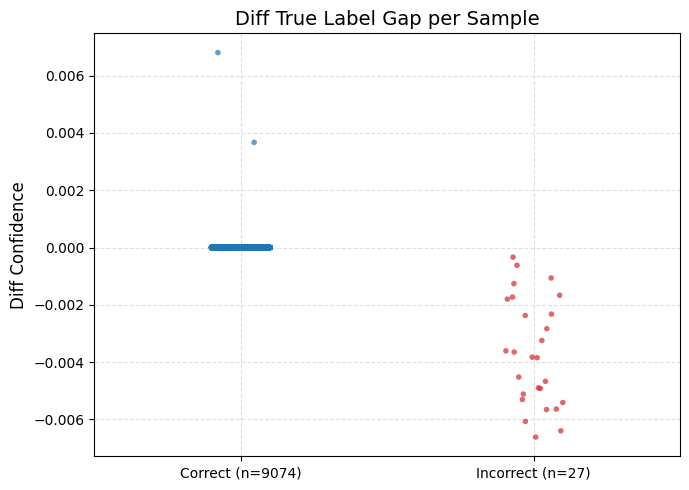

correct_loss: torch.Size([9074]), incorrect_loss: torch.Size([27])


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: Passing `palette` without assigning `hue` is deprecated.


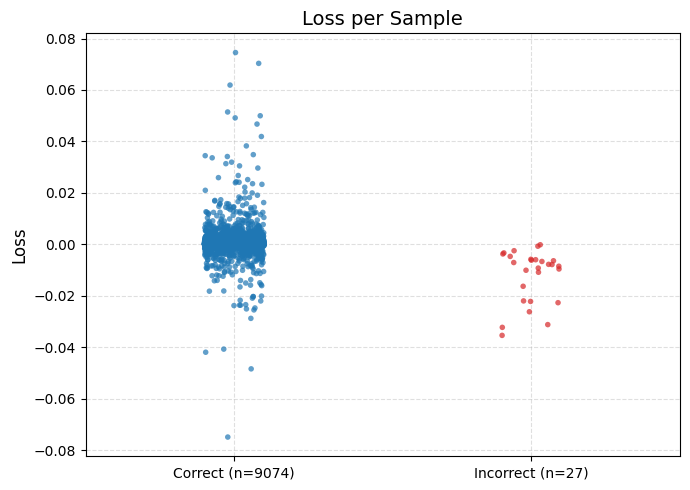

op: suppress:   0%|          | 0/313 [00:00<?, ?it/s]

all_logits.shape: (10000, 100), all_proba.shape: (10000, 100), all_pred_labels.shape: (10000,)
diff_correct: (9074,), diff_incorrect: (27,)
diff_diff_correct: (9074,), diff_diff_incorrect: (27,)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: Passing `palette` without assigning `hue` is deprecated.


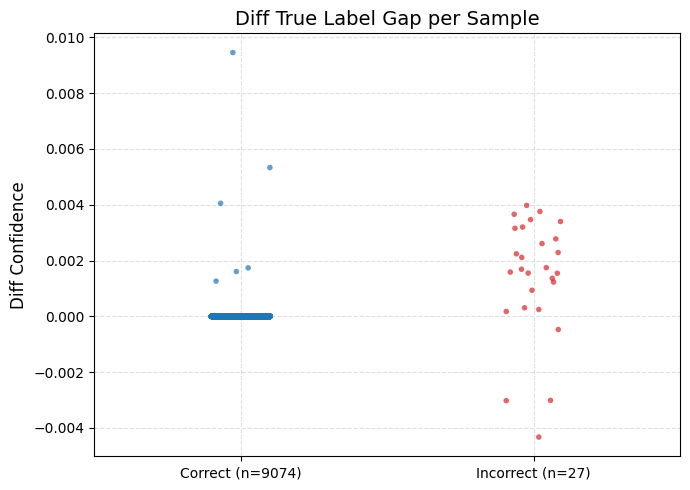

correct_loss: torch.Size([9074]), incorrect_loss: torch.Size([27])


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: Passing `palette` without assigning `hue` is deprecated.


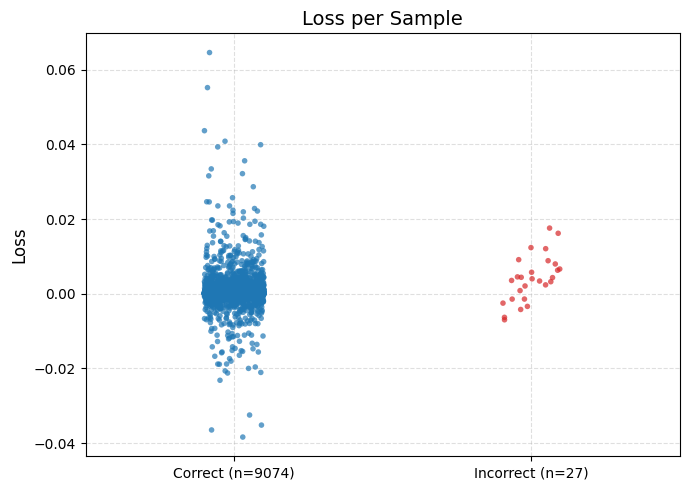

In [86]:
labels_tensor = torch.from_numpy(true_labels)

for op in ["enhance", "suppress"]:
    model_copy = ViTForImageClassification.from_pretrained(pretrained_dir).to(device)
    vit_from_last_layer = ViTFromLastLayer(model_copy)
    vit_from_last_layer.eval()
    dummy_in = [0] * (len(pos_before) + len(pos_after))
    set_new_weights(dummy_in, pos_before, pos_after, vit_from_last_layer, op=op)
    _ = vit_from_last_layer(hidden_states_before_layernorm=clean_hs[0], tgt_pos=tgt_pos)

    all_logits_new = []
    all_proba_new = []
    all_pred_labels_new = []
    for cached_state in tqdm(clean_hs, total=len(clean_hs), desc=f"op: {op}"):
        # ここでViTFromLastLayerのforwardが実行される
        logits = vit_from_last_layer(hidden_states_before_layernorm=cached_state, tgt_pos=tgt_pos)
        proba = torch.nn.functional.softmax(logits, dim=-1)
        logits = logits.detach().cpu().numpy()
        proba = proba.detach().cpu().numpy()
        all_logits_new.append(logits)
        all_proba_new.append(proba)
    all_logits_new = np.concatenate(all_logits_new, axis=0)
    all_proba_new = np.concatenate(all_proba_new, axis=0)
    all_pred_labels_new = all_logits_new.argmax(axis=-1)
    print(f"all_logits.shape: {all_logits_new.shape}, all_proba.shape: {all_proba_new.shape}, all_pred_labels.shape: {all_pred_labels_new.shape}")
    
    logits_tensor = torch.from_numpy(all_logits_new)
    
    # originalで正解/不正解だったサンプルへのprobaを取得
    correct_proba = all_proba_new[correct_indices]
    incorrect_proba = all_proba_new[incorrect_indices]
    # originalで正解/不正解だったサンプルへの予測ラベルを取得
    top_indices_correct = correct_proba.argmax(axis=1)  # shape: (num_correct,)
    top_indices_incorrect = incorrect_proba.argmax(axis=1)  # shape: (num_incorrect,)
    # 予測値最大の確率値(予測値)のリスト
    top_confidences_correct = correct_proba[
        np.arange(len(correct_proba)), 
        top_indices_correct
    ]
    top_confidences_incorrect = incorrect_proba[
        np.arange(len(incorrect_proba)), 
        top_indices_incorrect
    ]
    # 正解時/不正解時それぞれの正解ラベルのリスト
    labels_when_correct = labels_tensor[correct_indices]
    labels_when_incorrect = labels_tensor[incorrect_indices]
    # 正解時/不正解時それぞれの正解ラベルへの予測確率値のリスト
    correct_confidences = correct_proba[np.arange(len(correct_proba)), labels_when_correct]
    incorrect_confidences = incorrect_proba[np.arange(len(incorrect_proba)), labels_when_incorrect]
    diff_correct = top_confidences_correct - correct_confidences
    diff_incorrect = top_confidences_incorrect - incorrect_confidences
    print(f"diff_correct: {diff_correct.shape}, diff_incorrect: {diff_incorrect.shape}")
    diff_diff_correct = diff_correct - results_dict[(misclf_type, tgt_rank, fpfn)]["diff_correct"]
    diff_diff_incorrect = diff_incorrect - results_dict[(misclf_type, tgt_rank, fpfn)]["diff_incorrect"]
    print(f"diff_diff_correct: {diff_diff_correct.shape}, diff_diff_incorrect: {diff_diff_incorrect.shape}")
    plot_dot_violin(diff_diff_correct, diff_diff_incorrect, set_ylim=None, ylabel="Diff Confidence", title="Diff True Label Gap per Sample")
    
    # ロスのdiff
    labels_when_correct = labels_tensor[correct_indices]
    labels_when_incorrect = labels_tensor[incorrect_indices]
    correct_loss = criterion(logits_tensor[correct_indices], labels_when_correct)
    incorrect_loss = criterion(logits_tensor[incorrect_indices], labels_when_incorrect)
    print(f"correct_loss: {correct_loss.shape}, incorrect_loss: {incorrect_loss.shape}")
    diff_correct_loss = correct_loss - results_dict[(misclf_type, tgt_rank, fpfn)]["correct_loss"]
    diff_incorrect_loss = incorrect_loss - results_dict[(misclf_type, tgt_rank, fpfn)]["incorrect_loss"]
    plot_dot_violin(diff_correct_loss, diff_incorrect_loss, set_ylim=None, ylabel="Loss", title="Loss per Sample")
    

1つず色々みたけど一貫した特徴がない．これでは良くなってるかどうかが運ゲー．

そこで，何らかの指標を立ててそれを統計的に見ることで全体の特徴を理解したい．